# A/B-тестирование и приоритизация гипотез

В первой части исследования нам предстоит приоритизировать гипотезы для очерёдности их выполнения.\
В файле *hypothesis.csv* подготовлены 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами:
- Reach - охват,
- Impact - влияние,
- Confidence - уверенность,
- Effort - усилия.
Для этого применим фреймворки ICE и RICE и посмотрим как меняется приоритизация между ними.

Во второй части исследования нам нужно ознакомиться с результатами проведённого A/B-теста, которые описаны в файлах *orders.csv* и *visitors.csv*.\
Проанализируем данные и подготовим решение о продолжении теста или подведём итог по его завершению.


## Подготовим данные для исследования

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

### Подгружаем датасеты

In [2]:
hypos = pd.read_csv('\hypothesis.csv')
orders = pd.read_csv('\orders.csv')
visitors = pd.read_csv('\visitors.csv')

### Ознакомимся с данными

In [3]:
pd.options.display.max_colwidth = 130
hypos

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
display(
    orders.info(),
    orders.sample(5)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
770,1907905097,3906435972,2019-08-05,1870,B
235,395889669,2873491771,2019-08-23,599,B
640,3730164576,1476741193,2019-08-04,15485,B
419,884458775,1831227158,2019-08-06,1950,B
1192,2662137336,3733762160,2019-08-14,6490,B


In [5]:
display(
    visitors.info(),
    visitors.sample(5)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
29,2019-08-30,A,490
30,2019-08-31,A,699
28,2019-08-29,A,577
31,2019-08-01,B,713
45,2019-08-15,B,544


### Преобразуем столбцы с датой к нужному типу

In [6]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

display(
    orders.info(),
    visitors.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

None

### Посмотрим количество групп A/B-теста и период проведения

In [7]:
display(
    orders['group'].unique(),
    visitors['group'].unique()
)

array(['B', 'A'], dtype=object)

array(['A', 'B'], dtype=object)

In [8]:
display(
    orders['date'].min(),
    visitors['date'].min(),
    orders['date'].max(),
    visitors['date'].max()
)

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Timestamp('2019-08-31 00:00:00')

Групп по А/В-тесту две в обеих таблицах.\
Период проведения теста - с 1 по 31 августа 2019 года. 

### Проверка на дубликаты пользователей в группах А/В-теста

In [9]:
visitorsA = orders.loc[orders['group'] == 'A', 'visitorId'].drop_duplicates(keep='first')
visitorsB = orders.loc[orders['group'] == 'B', 'visitorId'].drop_duplicates(keep='first')
duplicates = visitorsA[visitorsA.isin(visitorsB)]

display(
    'Количество пользователей в группе А:', visitorsA.count(),
    'Количество пользователей в группе В:', visitorsB.count(),
    'Количество дубликатов в каждой группе:', duplicates.count()
)

'Количество пользователей в группе А:'

503

'Количество пользователей в группе В:'

586

'Количество дубликатов в каждой группе:'

58

Обнаружили 58 пользователей, которых зачислили в обе группы А/В-теста.\
Исключим дубликаты из датасета, чтобы исключить возможность сделать ошибку в решении по тесту.

In [10]:
orders = orders[~(orders['visitorId'].isin(duplicates))]
display(
    'Количество пользователей в группе А после удаления дубликатов:', orders.loc[orders['group'] == 'A', 'visitorId'].nunique(),
    'Количество пользователей в группе В после удаления дубликатов:', orders.loc[orders['group'] == 'B', 'visitorId'].nunique()
)

'Количество пользователей в группе А после удаления дубликатов:'

445

'Количество пользователей в группе В после удаления дубликатов:'

528

### Посмотрим ежедневную динамику посетителей онлайн-магазина по группам

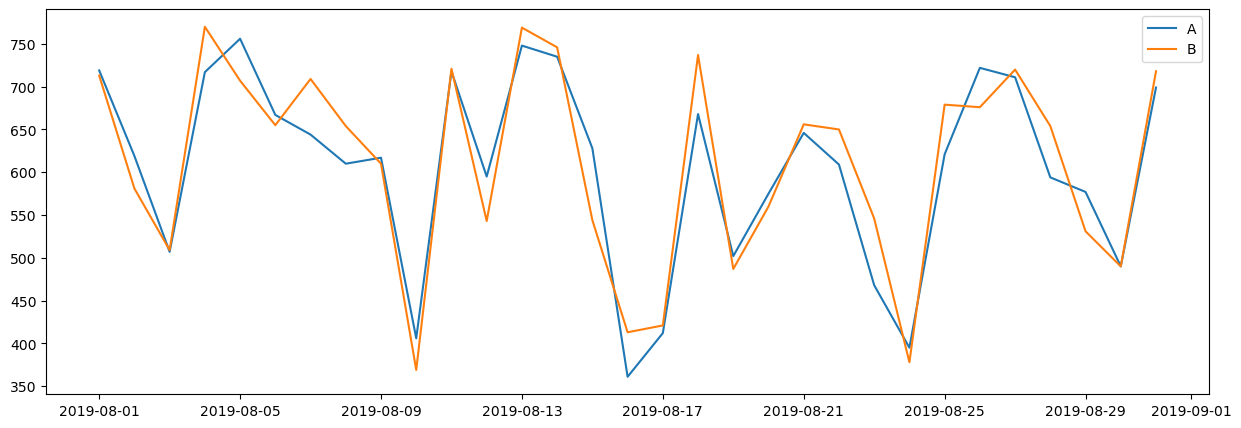

In [11]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(visitors.loc[visitors['group'] == 'A', 'date'], visitors.loc[visitors['group'] == 'A', 'visitors'], label='A')
plt.plot(visitors.loc[visitors['group'] == 'B', 'date'], visitors.loc[visitors['group'] == 'B', 'visitors'], label='B')
plt.legend()
plt.show()

### Промежуточные итоги
Ознакомившись с данными в таблицах, узнали период проведения А/В-теста - с 1 по 31 августа 2019 года.\
В обеих таблицах 2 группы для теста: А и В.\
Также привели даты к типу *datetime*.

Проверили дубликаты пользователей, которые попали в обе группы А/В-теста:
- обнаружили 58 пользователей, которые относились сразу к обеим группам, и исключили их.
- после исправления дубликатов в группе А осталось 445 человек, группа В уменьшилась до 528.

По группам динамика посещения онлайн-магазина без сильных различий.

Можем приступать к основной части проекта.

## Приоритизация гипотез
Проверим 9 гипотез и расставим их по приоритету согласно разным фреймворкам.

### Применим фреймворк ICE для приоритизации гипотез и отсортируем по убыванию приоритета

In [12]:
hypos['ICE'] = round(hypos['Impact'] * hypos['Confidence'] / hypos['Efforts'], 1)
hypos[['Hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


### Применим фреймворк ICE для приоритизации гипотез и отсортируем по убыванию приоритета

In [13]:
hypos['RICE'] = round(hypos['Reach'] * hypos['Impact'] * hypos['Confidence'] / hypos['Efforts'], 1)
hypos[['Hypothesis', 'RICE', 'ICE']].sort_values('RICE', ascending=False)

,Hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.1
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.0


### Произошли изменения в приоритизации гипотез при применении RICE вместо ICE
У гипотезы **"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - самый большой охват аудитории**, что подняло её ценность по RICE.\
Также Reach помог гипотезе **"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"** подняться на 2-е место.\
А вот гипотеза **"Запустить акцию, дающую скидку на товар в день рождения"**, которая была лидером по фреймворку ICE не набрала дополнительных баллов, т.к. у неё минимальный охват - 1, и откатилась на 5-е место по RICE.

Следовательно, если есть возможность оценить охват аудитории, то фреймворк RICE может показать более точную приоритизацию.

## Анализ A/B-теста

### Построим график кумулятивной выручки по группам

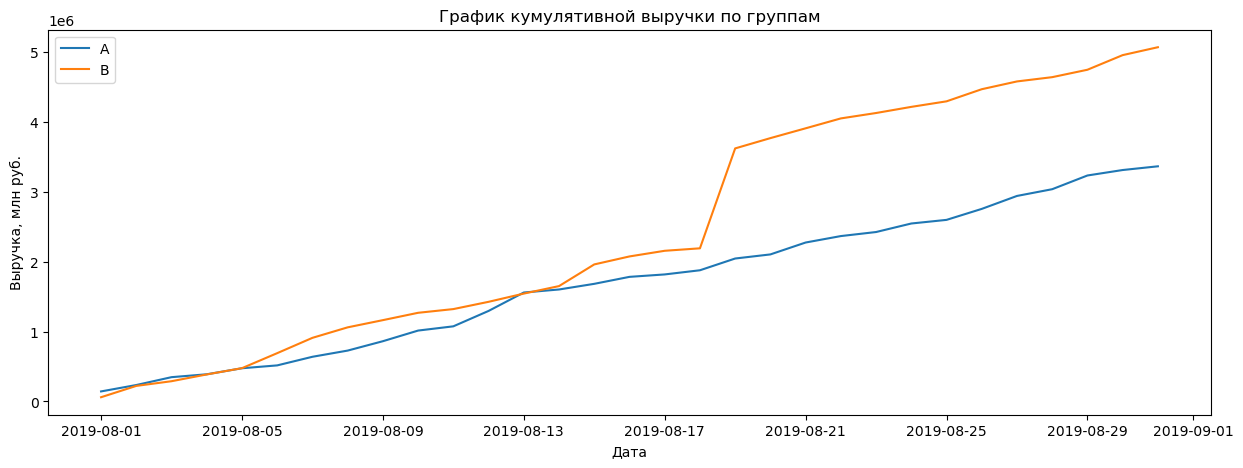

In [14]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.rcParams["figure.figsize"] = (15, 5)
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн руб.')
plt.legend()
plt.show()

Согласно графику у группы В в отдельном отрезке резко выросла выручка, группа А равномерно растёт весь период.\
Чтобы точно понять причины такого роста посмотрим как себя вели за тот же период средний чек и конверсия пользователей.

### Построим график кумулятивного среднего чека по группам

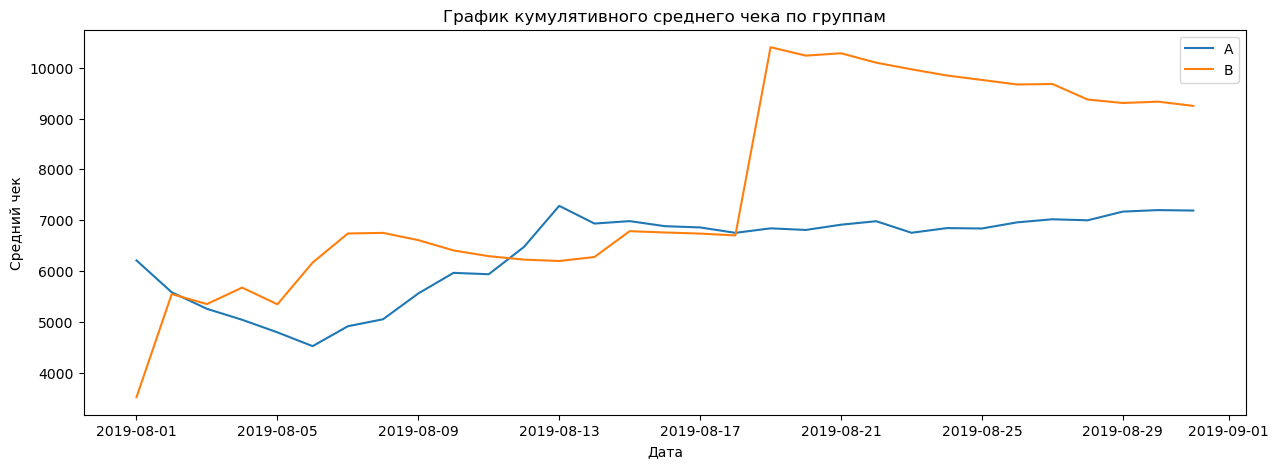

In [15]:
plt.rcParams["figure.figsize"] = (15, 5)
# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.show()

Средний чек у группы В, как и выручка, резко вырос на отдельном отрезке.\
У группы А во второй половине проведения теста стабилизировался показатель среднего чека.\
Посмотрим график относительного изменения кумулятивного среднего чека между группами.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

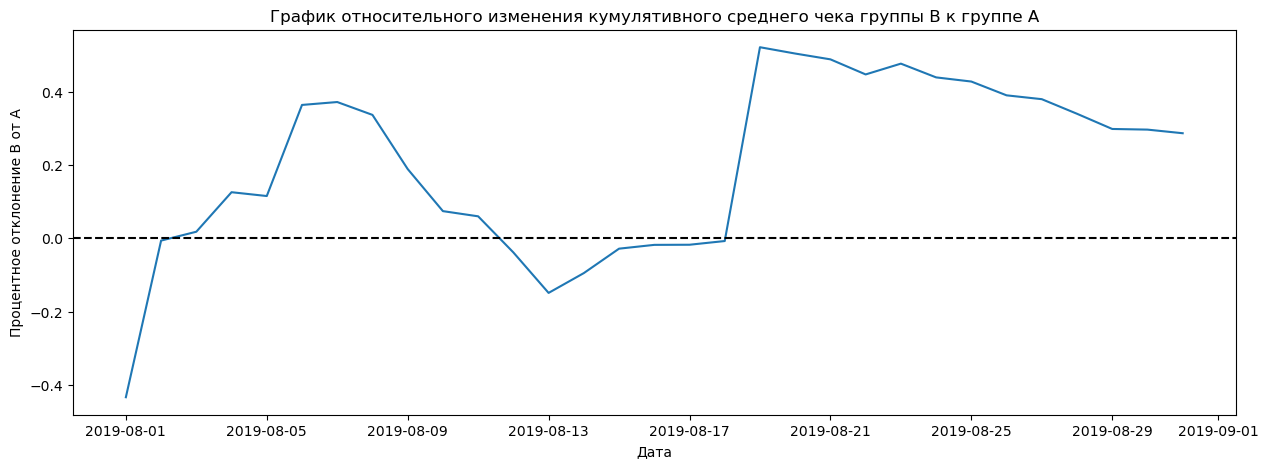

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

plt.rcParams["figure.figsize"] = (15, 5)
# cтроим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1,
    label='Изменение среднего чека В относительно А'
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Процентное отклонение В от А')
plt.show()

В первой половине графика у группы А был низкий средний чек, из-за чего появился первый скачок.\
Во второй половине средний чек в группе А был стабилен, и скачок возник из-за заказов группы В.\
Точно были крупные заказы в группе В, т.к. после всплеска средний чек старается "устаканиться".\
В дальнейшем проверим нужно ли нам от таких заказов избавиться для чистоты проведения теста.\
А сейчас посмотрим конверсию заказов на посетителя по группам.

### Построим график кумулятивного среднего количества заказов на посетителя по группам

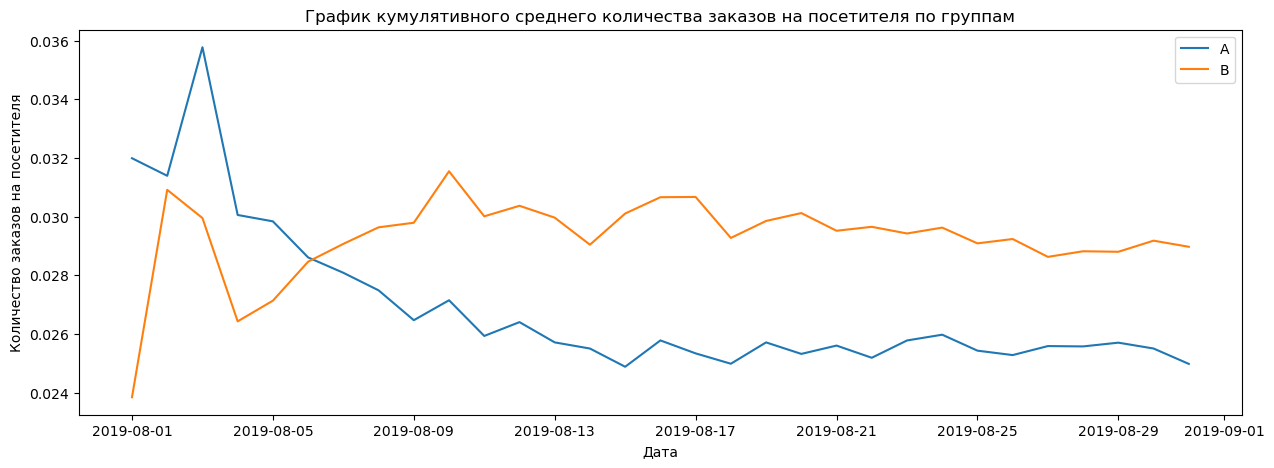

In [17]:
# датафрейм с кумулятивным количеством заказов на посетителя по дням в группе А
cumulativeOrdersA = cumulativeData[cumulativeData['group']=='A'][['date','visitors', 'orders']]

# датафрейм с кумулятивным количеством заказов на посетителя по дням в группе B
cumulativeOrdersB = cumulativeData[cumulativeData['group']=='B'][['date','visitors', 'orders']]

plt.rcParams["figure.figsize"] = (15, 5)
# Строим количества заказов группы А
plt.plot(cumulativeOrdersA['date'], cumulativeOrdersA['orders']/cumulativeOrdersA['visitors'], label='A', )

# Строим количества заказов группы B
plt.plot(cumulativeOrdersB['date'], cumulativeOrdersB['orders']/cumulativeOrdersB['visitors'], label='B')

plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов на посетителя')
plt.legend()
plt.show()

В начале теста был разброс по количеству заказов, ближе к середине показатели стабилизировались и группа В уверенно лидирует по этому параметру.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

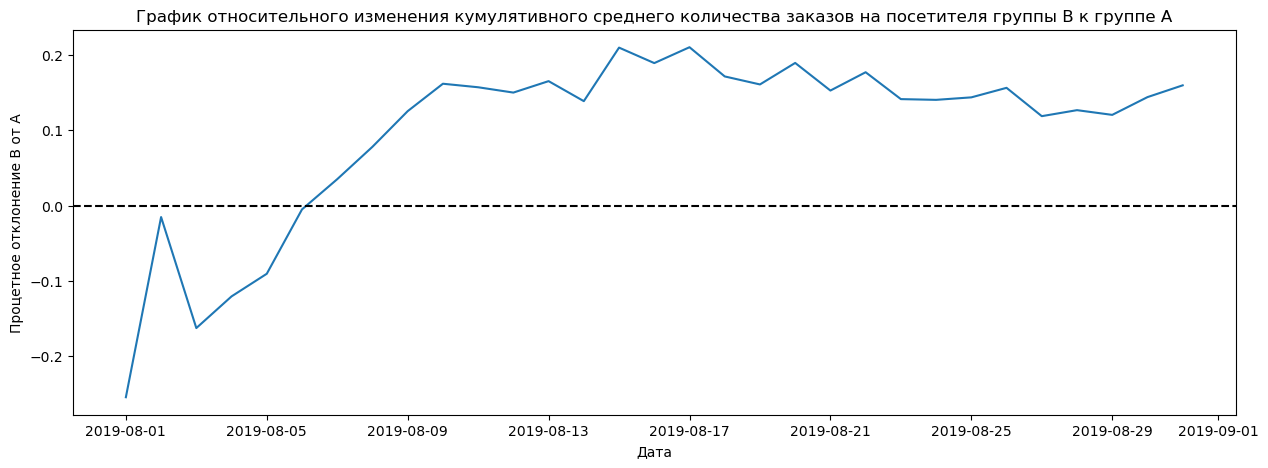

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeOrders = cumulativeOrdersA.merge(
    cumulativeOrdersB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

plt.rcParams["figure.figsize"] = (15, 5)
# cтроим отношение средних количества заказов на посетителя
plt.plot(
    mergedCumulativeOrders['date'],
    (mergedCumulativeOrders['ordersB']/mergedCumulativeOrders['visitorsB'])/(mergedCumulativeOrders['ordersA']/mergedCumulativeOrders['visitorsA'])-1,
    label='Изменение среднего количества заказов на посетителя В относительно А'
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Процетное отклонение В от А')
plt.show()

Конверсия в первой половине имела всплески, вторую половину теста показатели шли без сильных скачков.\
**Значит аномальный рост выручки связан с крупными заказами, т.к. конверсия не менялась, а средний чек также подскочил**.

### Построим точечный график количества заказов по пользователям

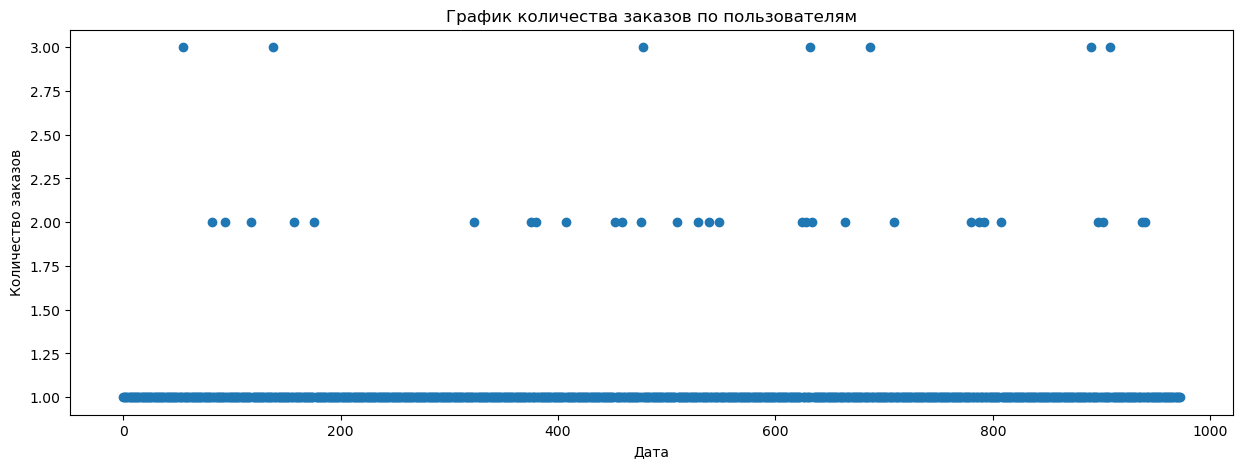

In [19]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.rcParams["figure.figsize"] = (15, 5)
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов по пользователям')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Видно, что большинство пользователей делали 1-2 заказа.\
Покупатели с 3 заказами встречаются заметно реже.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей

In [20]:
print(np.percentile(ordersByUsers['orders'], [95, 97.5, 99]))

[1. 2. 2.]


99-й перцентиль - пользователи с 2 заказами.
Возьмём этот показатель за границу нормальности - исключим из теста пользователей с 3 заказами и более.

### Построим точечный график стоимостей заказов

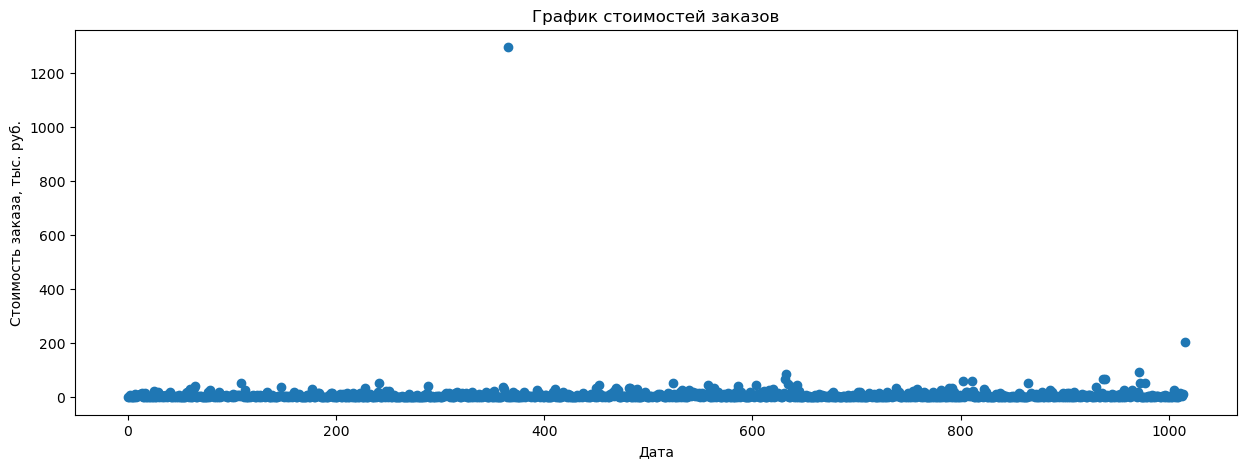

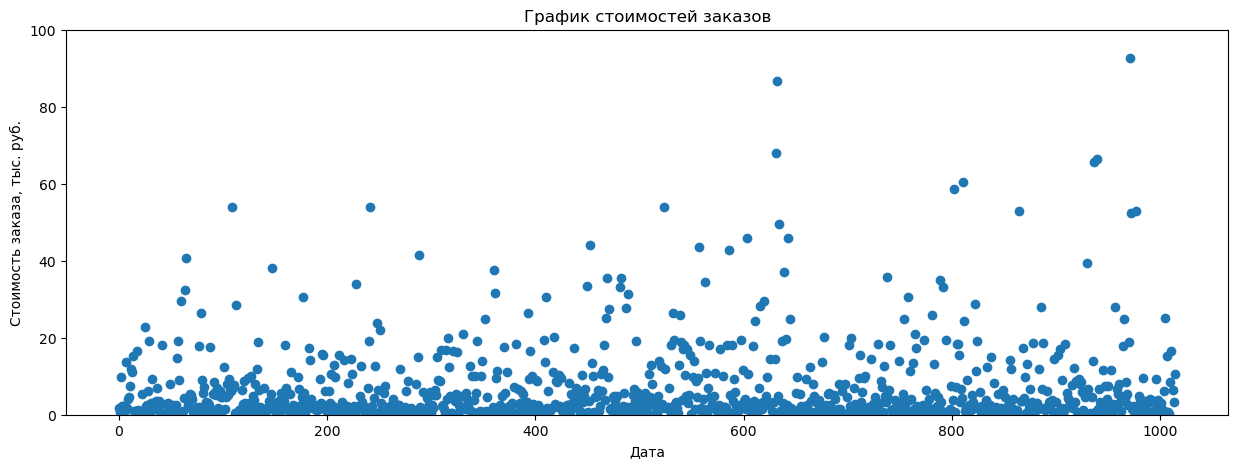

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))
y_values = orders['revenue'] / 1000

plt.rcParams["figure.figsize"] = (15, 5)
plt.scatter(x_values, y_values)
plt.title('График стоимостей заказов')
plt.xlabel('Дата')
plt.ylabel('Стоимость заказа, тыс. руб.')
plt.show()

plt.scatter(x_values, y_values)
plt.ylim(0, 100)
plt.title('График стоимостей заказов')
plt.xlabel('Дата')
plt.ylabel('Стоимость заказа, тыс. руб.')
plt.show()

Большинство заказов стоят менее 100 тысяч рублей. 2 заказа сильно выбиваются из общей массы.

### Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных заказов

In [22]:
print(np.percentile(orders['revenue'], [95, 97.5, 99])) 

[26785. 37400. 53904.]


99-й перцентиль - заказы стоимостью 53904 руб.\
Возьмём эту цифру для исключения аномалий, т.к. эта сумма не сильно выбивается из общей массы, и отбросим только 1% довольно крупных заказов.

### Гипотезы:
- нулевая: между группами нет статистически значимых различий по среднему количеству заказов на посетителя.
- альтернативная: статистически значимое различие между группами есть.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [23]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'count'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'count'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительное различие группы В относительно группы А по среднему количеству заказов: {0:.2f}%".format((sampleB.mean() / sampleA.mean() - 1) * 100))

p-value: 0.011
Относительное различие группы В относительно группы А по среднему количеству заказов: 15.98%


По «сырым» данным **есть статистически значимое различие между группами по среднему количеству заказов на посетителя**.\
Группа В имеет на 15.98% больше заказов на посетителя.

### Гипотезы:
- нулевая: между группами нет статистически значимых различий по среднему чеку заказов.
- альтернативная: статистически значимое различие между группами по среднему чеку заказов есть.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [24]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие группы В относительно группы А по среднему чеку: {0:.2f}%'.format((orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1) * 100))

p-value: 0.829
Относительное различие группы В относительно группы А по среднему чеку: 28.66%


По «сырым» данным **статистически значимого различия между группами по среднему чеку заказов нет**.\
При этом средний чек группы В на 28.66% больше - скорее всего сыграли роль аномально крупные заказы.\
Теперь исключим выбросы и посмотрим как изменятся показатели.

### Очистим данные от аномальных значений превышающие 99-й перцентиль:
- исключим пользователей, у которых более 2 заказов.
- исключим заказы с суммой более 53904 рублей.

In [25]:
orders_count = 2
orders_amount = 53904

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_count]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_count]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > orders_amount]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

### Гипотезы:
- нулевая: между группами нет статистически значимых различий по среднему количеству заказов на посетителя.
- альтернативная: статистически значимое различие между группами есть.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [26]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие группы В относительно группы А по среднему количеству заказов: {0:.2f}%'.format((sampleBFiltered.mean()/sampleAFiltered.mean()-1) * 100))

0.007
Относительное различие группы В относительно группы А по среднему количеству заказов: 18.92%


После исключения аномалий **статистически значимое различие между группами по среднему количеству заказов на посетителя сохранилось**.\
А относительное различие группы В от группы А по среднему количеству заказов увеличилось с 15.98% до 18.92%.

### Гипотезы:
- нулевая: между группами нет статистически значимых различий по среднему чеку заказов.
- альтернативная: статистически значимое различие между группами по среднему чеку заказов есть.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [27]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительное различие группы В относительно группы А по среднему чеку: {0:.2f}%".format(
        (orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1) * 100
    )
)

0.788
Относительное различие группы В относительно группы А по среднему чеку: -3.23%


После исключения аномалий **статистически значимого различия между группами по среднему чеку заказов также нет**.\
При этом средний чек группы В теперь меньше среднего чека в группе А: изменился с 28.66% на -3.23%.\
Как раз сыграло роль исключение аномально крупных заказов, что выровняло показатель между группами.

### Решение: тест остановить и признать удачным, т.к. обнаружено статистическое различие между группами по количеству заказов на пользователя.
Задачей в нашем исследовании было увеличить выручку компании.\
Считаю, что тест можно признать удачным, т.к. **есть статистическое различие в количестве заказов на посетителя между группами**.\
Дальше **продолжать тест не имеет смысла, т.к. данные к середине периода проведения теста стабилизировались и сильных колебаний в показателях не было, кроме выброса вызванных крупными заказами.**

## Подведение итогов
В рамках исследования нам предстояло помочь интернет-магазину приоритизировать гипотезы и с помощью A/B-теста понять сработала ли она.

С помощью фреймворков ICE и RICE расположили гипотезы по приоритету и увидели различия между полученными данными. На это повлиял показатель Reach - охват аудитории.\
Т.к. **у гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" самый большой охват аудитории - она самая приоритетная цель**.\
Также Reach помог гипотезе **"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"** подняться на 2-е место.\
А вот гипотеза **"Запустить акцию, дающую скидку на товар в день рождения"**, которая была лидером по фреймворку ICE не набрала дополнительных баллов, т.к. у неё минимальный охват - 1, и откатилась на 5-е место по RICE.\
Вывод по первой части можно сделать такой - **если есть возможность оценить охват аудитории, то фреймворк RICE может показать более точную приоритизацию по сравнению с ICE**.

Во второй части исследования нам были предоставлены данные по двум группам: А и В, за период с 1 по 31 августа 2019 года.\
От нас требовалось ознакомиться с данными проведённого A/B-теста и принять решение о продолжении или подвести его итог.\
По «сырым» данным были заметны выбросы в группе В. Рассчитали границу аномалий - взяли 99-й перцентиль:
- по количеству заказов на пользователя - исключили покупателей, у которых более 2 заказов.
- по сумме заказа - исключили заказы свыше 53904 рублей.
И рассчитали статистическое различие между группами по «сырым» данным, а также после исключения аномалий.

Итог:
- **по среднему чеку статистически значимого различия между группами нет**. При этом после удаления аномально крупных заказов **средний чек группы В меньше среднего чека в группе А на 3.23%**.
- **обнаружили статистически значимое различие между группами по среднему количеству заказов на посетителя**. В процентном отношении **среднее количество заказов на посетителя в группе В больше на 15.98% до исключения аномалий, и на 18.92% - после**.

Задачей в нашем исследовании было увеличить выручку компании.\
Считаю, что **тест нужно признать удачным**, т.к. при близких показателях в средних чеках, есть статистическое различие в количестве заказов на посетителя между группами - **пользователи в группе В чаще совершали заказы, при равном среднем чеке с группой А, что увеличило выручку онлайн-магазина**.\
**Продолжать А/В-тест не имеет смысла т.к. данные к середине периода проведения теста стабилизировались и сильных изменений в результатах не было**.